In [1]:
import numpy as np
import random

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from tqdm import tqdm
from tqdm import trange
import time

import os
import math
from math import sin
from icecream import ic
import json
import argparse

# checklist 1: uncomment matplotlib.use('Agg')
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline  

# plt.style.use('dark_background')

from scipy.io import loadmat
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

i_seed = 0

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import PIL

import sys

sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from plotting_tools import *
# from preprocessing import *
# from feature_extraction import *
# from data_pulling import *
# from setting import *
# from surrogate_extraction import *
# from evaluate import *
# from training_util import *
# from dataset_util import *
# from evaluation_util import *

from plotting_tools import *
from preprocessing import *
from setting import *
from surrogate_extraction import *
from dataIO import *
from filters import *
from spectral_module import *
from stage4_regression import *
# from unet_extension.dataset_util import *
# from unet_extension.evaluation_util import *
# from unet_extension.models import *
# from unet_extension.training_util import *


import datetime
import time

# checklist 2: comment out all magic command
from importlib import reload
%load_ext autoreload
%autoreload 2


In [2]:
# Fs = FS_RESAMPLE

# label_names = ['br', 'heart_rate_cosmed', 'rer', 'vco2_ml_min', 've', 'vo2_ml_min', 'vt']
# sig_names = ['ECG', 'accelX', 'accelY', 'accelZ']

In [3]:
parser = argparse.ArgumentParser(description='RR_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
# args = parser.parse_args(['--input_folder', '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AMpt_norm_script1/', 
args = parser.parse_args(['--input_folder', '../../data/stage4_UNet/', 
# args = parser.parse_args(['--input_folder', '../../data/stage4_UNet/', 
                          '--output_folder', '../../data/stage5_UNet/'])


# Estimation_EE/data/stage4_UNet/test/win60_overlap95_seq20_norm/target


# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage4_UNet/', output_folder='../../data/stage5_UNet/', training_params_file='training_params_list.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
# outputdir = outputdir+inputdir.split('/')[-2]+'/'

# training_params_file = args.training_params_file

In [5]:
# inputdir = inputdir+'win60_overlap95_seq20_norm/'

In [6]:
steps_thre = 100
list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']
list_method = ['ST', 'U-Net', 'U-Net RQI_fft', 'U-Net RQI_kurtosis']

In [7]:
inputdir

'../../data/stage4_UNet/'

In [8]:
def get_RQI_threshold(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
    MAE_diff = df_RQI_results['MAE'].values-1
#     MAE_diff = df_RQI_results['MAE'].values-1
    df_RQI_results['MAE_diff'] = MAE_diff
#     print(MAE_diff)
    
    if (MAE_diff<0).sum()!=0:
        i_RQI_threshold = np.where((MAE_diff<0) & (MAE_diff==MAE_diff[MAE_diff<0].max()))[0]
        i_RQI_threshold = i_RQI_threshold[-1]
        RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
    else:
        if RQI_name == 'RQI_fft':
            RQI_threshold=0.55
        elif RQI_name == 'RQI_kurtosis':
            RQI_threshold=0

#         i_RQI_threshold = MAE_diff.shape[0]//2
        
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold'].values

    # i_RQI_threshold/ 
#     return RQI_threshold
    return RQI_threshold

In [9]:

def get_mask_random(N_zeros, N_ones, i_seed=0):
    # create a mask with N_zeros and N_ones
    # default seed is 0
    mask_random = [0] * N_zeros + [1] * N_ones
    random.seed(i_seed)
    random.shuffle(mask_random)
    mask_random = np.asarray(mask_random).astype(bool)
    return mask_random

def get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=10):
    
    df_RQI_results = pd.DataFrame()

    label = df_outputlabel['label'].values
    label_est = df_outputlabel['label_est'].values

    if RQI_name!='random':
        RQI_range = df_outputlabel[RQI_name].min(), df_outputlabel[RQI_name].max()
    else:
        RQI_range = [0,df_outputlabel.shape[0]]
        
        
    for threshold in np.linspace(RQI_range[0],RQI_range[1],steps_thre, endpoint=False):

        if RQI_name!='random':
            mask_RQI = df_outputlabel[RQI_name] > threshold
#             MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
        else:
            # random rejection
            N_zeros = int(threshold)
            N_ones = df_outputlabel.shape[0] - N_zeros
            mask_RQI = get_mask_random(N_zeros, N_ones)
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        df_RQI_results = df_RQI_results.append(
            pd.DataFrame(
                {
                    'threshold': threshold,
                    'coverage': mask_RQI.mean()*100,
                    'MAE': MAE,
                }, index=[0]
        ))

    df_RQI_results = df_RQI_results.reset_index(drop=True)
    return df_RQI_results

# get train data, compute threshold for RQI

In [10]:
os.listdir(inputdir)

['ECGPPG',
 'SCG',
 'PPG',
 '.ipynb_checkpoints',
 'SCGPPG',
 'test',
 'All',
 'ECGSCG',
 'ECG']

In [11]:
TF_types = ['source', 'FT_top', 'FT_top2', 'FT_all', 'target']

In [12]:
os.listdir(inputdir)

['ECGPPG',
 'SCG',
 'PPG',
 '.ipynb_checkpoints',
 'SCGPPG',
 'test',
 'All',
 'ECGSCG',
 'ECG']

In [13]:

df_outputlabel_ALL_train = pd.DataFrame()

for sub_file in os.listdir(inputdir):
    
    if sub_file!='test':
        continue
    
    if '.ipynb_checkpoints'==sub_file:
        continue
        


    modality = sub_file
    
    inputdir_modality = inputdir + sub_file+'/win60_overlap95_seq20_norm/'
    
    for TF_type in os.listdir(inputdir_modality):

        if TF_type not in TF_types:
            continue
    
        csv_dir = inputdir_modality + TF_type+'/numeric_results/df_outputlabel_train_RR_cosmed.csv'
        df_outputlabel_train_RR_cosmed = pd.read_csv(csv_dir)  
        df_outputlabel_train_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_train_RR_cosmed['label_est'] - df_outputlabel_train_RR_cosmed['label'])

        df_outputlabel_train_RR_cosmed['modality'] = modality
        df_outputlabel_train_RR_cosmed['TF_type'] = TF_type
        df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net'

        df_outputlabel_ALL_train = df_outputlabel_ALL_train.append(df_outputlabel_train_RR_cosmed)

In [14]:
df_outputlabel_ALL_train


,label_est,label,task,CV,activity,RQI_fft,RQI_kurtosis,RQI_ideal,modality,TF_type,est_method
0,13.0,13.0,RR_cosmed,103,0,0.692226,49.997982,-0.0,test,FT_top2,U-Net
1,13.0,13.0,RR_cosmed,103,0,0.677285,49.968338,-0.0,test,FT_top2,U-Net
2,13.0,13.0,RR_cosmed,103,0,0.666057,48.196915,-0.0,test,FT_top2,U-Net
3,12.0,13.0,RR_cosmed,103,0,0.734986,25.276224,-1.0,test,FT_top2,U-Net
4,12.0,13.0,RR_cosmed,103,0,0.703752,49.145220,-1.0,test,FT_top2,U-Net
...,...,...,...,...,...,...,...,...,...,...,...
27687,19.0,19.0,RR_cosmed,120,5,0.703148,50.016220,-0.0,test,source,U-Net
27688,19.0,19.0,RR_cosmed,120,5,0.701667,50.015960,-0.0,test,source,U-Net
27689,19.0,19.0,RR_cosmed,120,5,0.700892,50.015667,-0.0,test,source,U-Net
27690,19.0,19.0,RR_cosmed,120,5,0.701326,50.015343,-0.0,test,source,U-Net


In [15]:
# plt.plot(df_outputlabel_ALL_train['RQI_fft'].values[::300])

In [16]:
df_RQI_threshold = pd.DataFrame()

for CV in df_outputlabel_ALL_train['CV'].unique():
    
    for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
        
        df_outputlabel = df_outputlabel_ALL_train[(df_outputlabel_ALL_train['CV']==CV) & (df_outputlabel_ALL_train['TF_type']==TF_type)]

        RQI_fft_threshold = get_RQI_threshold(df_outputlabel, 'RQI_fft', steps_thre=steps_thre)
        RQI_kurtosis_threshold = get_RQI_threshold(df_outputlabel, 'RQI_kurtosis', steps_thre=steps_thre)

        df_RQI_threshold = df_RQI_threshold.append(
            pd.DataFrame(
                {
                    'CV': CV,
                    'TF_type': TF_type,
                    'RQI_fft_threshold': RQI_fft_threshold,
                    'RQI_kurtosis_threshold': RQI_kurtosis_threshold,
                }, index=[0]
            )
        )


In [17]:
df_RQI_threshold

,CV,TF_type,RQI_fft_threshold,RQI_kurtosis_threshold
0,103,FT_top2,0.380436,42.996091
0,103,target,0.087120,3.272875
0,103,FT_top,0.530823,42.757327
0,103,FT_all,0.771038,6.830421
0,103,source,0.109210,21.135498
...,...,...,...,...
0,101,FT_top2,0.081358,0.000000
0,101,target,0.298952,47.914704
0,101,FT_top,0.155757,42.963094
0,101,FT_all,0.346936,36.943944


In [18]:
#  inputdir_modality + TF_type

# get val data

In [19]:

df_outputlabel_ALL = pd.DataFrame()


for sub_file in os.listdir(inputdir):
    
    if sub_file!='test':
        continue
    
    if '.ipynb_checkpoints'==sub_file:
        continue
        


    modality = sub_file
    
    inputdir_modality = inputdir + sub_file+'/win60_overlap95_seq20_norm/'
    
    for TF_type in os.listdir(inputdir_modality):

        if TF_type not in TF_types:
            continue

    #     csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_RR_cosmed.csv'
#         csv_dir = inputdir + sub_file+'/numeric_results/df_outputlabel_val_RR_cosmed.csv'
        csv_dir = inputdir_modality + TF_type+'/numeric_results/df_outputlabel_val_RR_cosmed.csv'

        df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
        df_outputlabel_val_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_RR_cosmed['label_est'] - df_outputlabel_val_RR_cosmed['label'])

    #     csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
#         csv_dir = inputdir + sub_file+'/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
        csv_dir = inputdir_modality + TF_type+'/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
        df_outputlabel_val_input_RR_cosmed = pd.read_csv(csv_dir)  
        df_outputlabel_val_input_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_input_RR_cosmed['label_est'] - df_outputlabel_val_input_RR_cosmed['label'])

        df_outputlabel_val_input_RR_cosmed['modality'] = modality
        df_outputlabel_val_input_RR_cosmed['est_method'] = 'ST'
        df_outputlabel_val_input_RR_cosmed['TF_type'] = TF_type

        df_outputlabel_val_RR_cosmed['modality'] = modality
        df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
        df_outputlabel_val_RR_cosmed['TF_type'] = TF_type


        df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_input_RR_cosmed)
        df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_RR_cosmed)

In [20]:
os.listdir(inputdir_modality)


['FT_top2', 'target', '.ipynb_checkpoints', 'FT_top', 'FT_all', 'source']

In [21]:
df_performance_agg = pd.DataFrame()

for modality in df_outputlabel_ALL['modality'].unique():
        
#     for est_method in df_outputlabel_ALL['est_method'].unique():
    for est_method in list_method:
        

        for TF_type in df_outputlabel_ALL['TF_type'].unique():
            
            if 'RQI' not in est_method:
                mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type)
                df_outputlabel = df_outputlabel_ALL[mask_df]
    #             MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
                coverage = 100

            else:
                mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type)

                df_outputlabel = df_outputlabel_ALL[mask_df]
                df_outputlabel= df_outputlabel.merge(df_RQI_threshold, on=['CV'])

                RQI_name = est_method.split(' ')[1]
                RQI_mask = df_outputlabel[RQI_name] > df_outputlabel[RQI_name+'_threshold']
                df_outputlabel = df_outputlabel[RQI_mask]
                coverage = RQI_mask.mean()*100

            MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
            PCC = get_PCC(df_outputlabel['label'], df_outputlabel['label_est'])
            CoeffDeterm = get_CoeffDeterm(df_outputlabel['label'], df_outputlabel['label_est'])
            MAPE, _ = get_MAPE(df_outputlabel['label'], df_outputlabel['label_est'])
            RMSE = get_RMSE(df_outputlabel['label'], df_outputlabel['label_est'])

            one_dict = {
                'MAE_mean': MAE_mean,
                'MAE_std': MAE_std,
                'PCC': PCC,
                'CoeffDeterm': CoeffDeterm,
                'MAPE': MAPE*100,
                'RMSE': RMSE,
                'method': est_method,
                'modality': modality,
                'TF_type': TF_type,
                'coverage': coverage,
            }

            df_performance_agg = df_performance_agg.append(one_dict, ignore_index=True)


In [22]:
df_performance_agg

,MAE_mean,MAE_std,PCC,CoeffDeterm,MAPE,RMSE,method,modality,TF_type,coverage
0,5.082406,7.327361,0.442225,-0.634777,24.518843,8.915937,ST,test,FT_top2,100.000000
1,5.082406,7.327361,0.442225,-0.634777,24.518843,8.915937,ST,test,target,100.000000
2,5.082406,7.327361,0.442225,-0.634777,24.518843,8.915937,ST,test,FT_top,100.000000
3,5.082406,7.327361,0.442225,-0.634777,24.518843,8.915937,ST,test,FT_all,100.000000
4,5.082406,7.327361,0.442225,-0.634777,24.518843,8.915937,ST,test,source,100.000000
5,2.548534,5.934299,0.619485,0.142589,11.818224,6.457021,U-Net,test,FT_top2,100.000000
6,1.750758,3.646363,0.831585,0.663675,9.510386,4.044057,U-Net,test,target,100.000000
7,2.581395,5.447101,0.666969,0.253096,12.360752,6.026567,U-Net,test,FT_top,100.000000
8,1.735086,3.627662,0.832125,0.667595,9.642974,4.020423,U-Net,test,FT_all,100.000000
9,2.678969,5.699486,0.640555,0.184717,12.571211,6.296395,U-Net,test,source,100.000000


In [23]:
method_color_dict = {
#     'temporal': '#2471A3',
    'ST': '#45B39D',
    'U-Net':'#F4D03F' ,
    'U-Net RQI_fft':'#b34b45' ,
    'U-Net RQI_kurtosis':'#c4751b' ,
}

In [24]:
# df['modality'] = pd.Categorical(df['modality'],list_modalitites.reverse(), ordered=True)
# df

In [29]:

def plot_metric(df, metric_name='CoeffDeterm', title_str=None):
#     metric_name = 'CoeffDeterm'

    # df = df_performance_agg.copy()

    df['method'] = pd.Categorical(
                df['method'], 
                categories=list_method,
                ordered=True
            )
    df = df.sort_values('method')


    df['modality'] = pd.Categorical(
                df['modality'], 
                categories=list_modalitites.reverse(), 
                ordered=True
            )
    df = df.sort_values('modality')

    fig, ax = plt.subplots(1,1, figsize=(7,3),dpi=100)

    sns.barplot(x="modality", y=metric_name, hue="method", data=df, ax=ax, palette=method_color_dict)
    ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.yaxis.grid(True, which='minor', alpha=0.5)
    ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
    
    if title_str is not None:
        ax.set_title(title_str)

    ax_no_top_right(ax)
    plt.show()

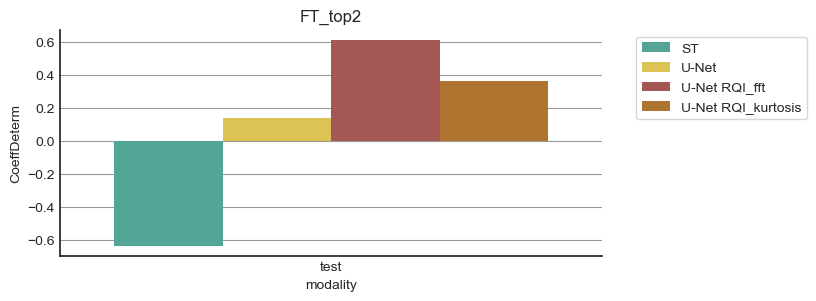

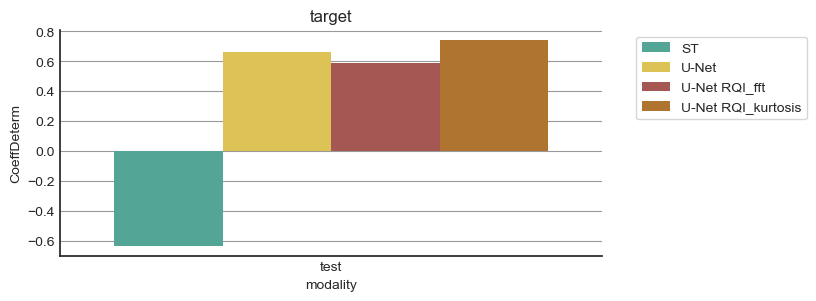

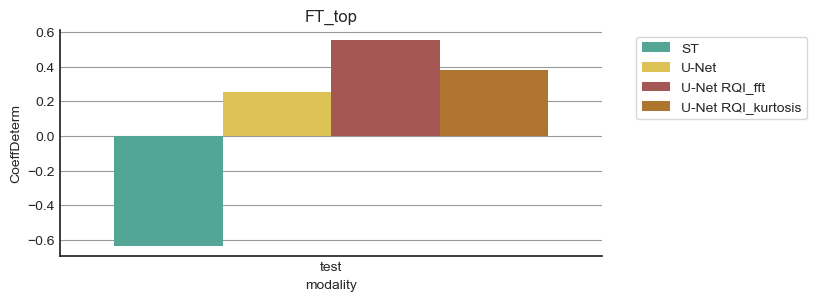

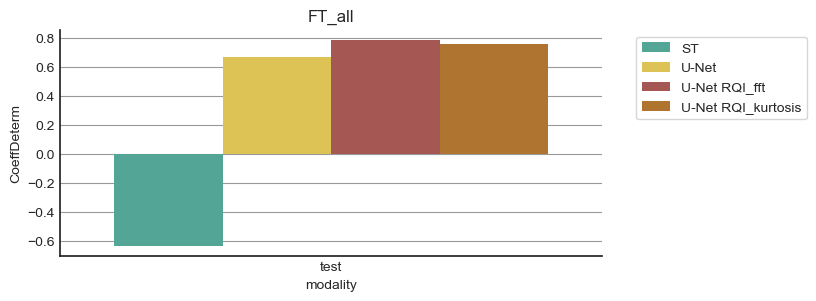

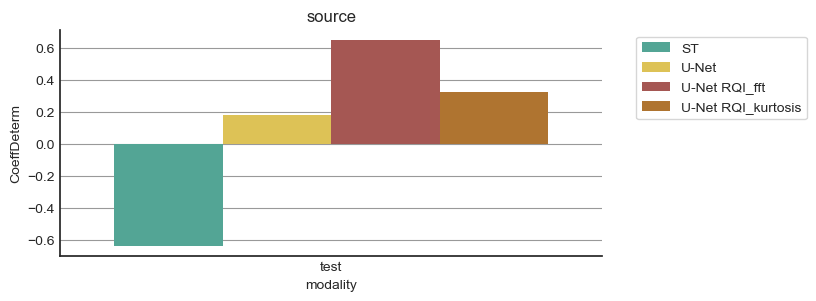

In [30]:
for TF_type in df_performance_agg['TF_type'].unique():
    df = df_performance_agg[df_performance_agg['TF_type']==TF_type].copy()
    metric_name = 'CoeffDeterm'
    plot_metric(df, metric_name=metric_name, title_str=TF_type)


In [27]:
# df = df_performance_agg[df_performance_agg['TF_type']=='target'].copy()
# metric_name = 'CoeffDeterm'
# plot_metric(df, metric_name=metric_name)


In [73]:
def plot_figure_ranking_all(df_performance_agg, outputdir=None, show_plot=False):

    fig = plt.figure(figsize=(10,10),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    fontsize = 15

    # Width of a bar 
    width = 0.2
    model_shift = 0 + width*1.5

    # ind = np.arange(len(df['input_name'].unique()))
    #     ind = np.asarray([0, 1, 2, 3, 4, 6, 5, 7])
    ind = np.arange(len(df_performance_agg['modality'].unique()))

    list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']

    # for method in df_performance_agg['method'].unique():
    for method in ['U-Net RQI_kurtosis', 'U-Net RQI_fft', 'U-Net', 'ST']:
        df = df_performance_agg[df_performance_agg['method']==method].copy()

        df['modality'] = pd.Categorical(
            df['modality'], 
            categories=list_modalitites, 
            ordered=True
        )
        df = df.sort_values('modality')

    #     legend_name = method
    #     if method=='ST+U-Net':
    #         legend_name = 'ST-U-Net'
    #         print(df)

        ax.barh(ind+model_shift, df['MAE_mean'].values , width, label=method, color=method_color_dict[method], zorder=3, alpha=0.9)
    # ax.barh(ind, MAE_input_single,  width, label='Demodulation', color='firebrick', zorder=3, alpha=0.9)

        ax.hlines(ind+model_shift, 0, df['MAE_std'].values, color='black')  # Stems
        ax.plot(df['MAE_std'].values, ind+model_shift, 'o', color='black')  # Stem ends


#         height = rect.get_height()
#         print(df['MAE_std'].values, ind+model_shift)
    
        
#         for (x_value, y_value, coverage) in zip(df['MAE_std'].values, ind+model_shift, df['coverage']):
        for (x_value, y_value, coverage) in zip(df['MAE_mean'].values*0, ind+model_shift, df['coverage']):
            if 'RQI' not in method:
                continue
            
#             print(x_value, y_value, coverage)
            ax.text(x_value+0.05, y_value, 'cov={:.1f}%'.format(coverage), ha='left', va='center', fontsize=fontsize*0.5, color='white',weight='bold')

        
        
        model_shift = model_shift - width


    ax.set_yticks(ind + (width-0.05) / 2)
    ax.set_yticklabels(df['modality'].unique())


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize+5)

    ax.legend(fontsize=fontsize, frameon=True, bbox_to_anchor=(1.04,1))
    ax.xaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.xaxis.grid(True, which='minor', alpha=0.5)
    # plt.majorticks_on() 
    plt.minorticks_on() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.tight_layout()

#         ax.set_xlim(0,4)

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure_rank_all.png', facecolor=fig.get_facecolor())
        
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

    # plot_figure7_ranking_all(df_join_methods, outputdir=outputdir, show_plot=True)


In [74]:
# df_performance_agg

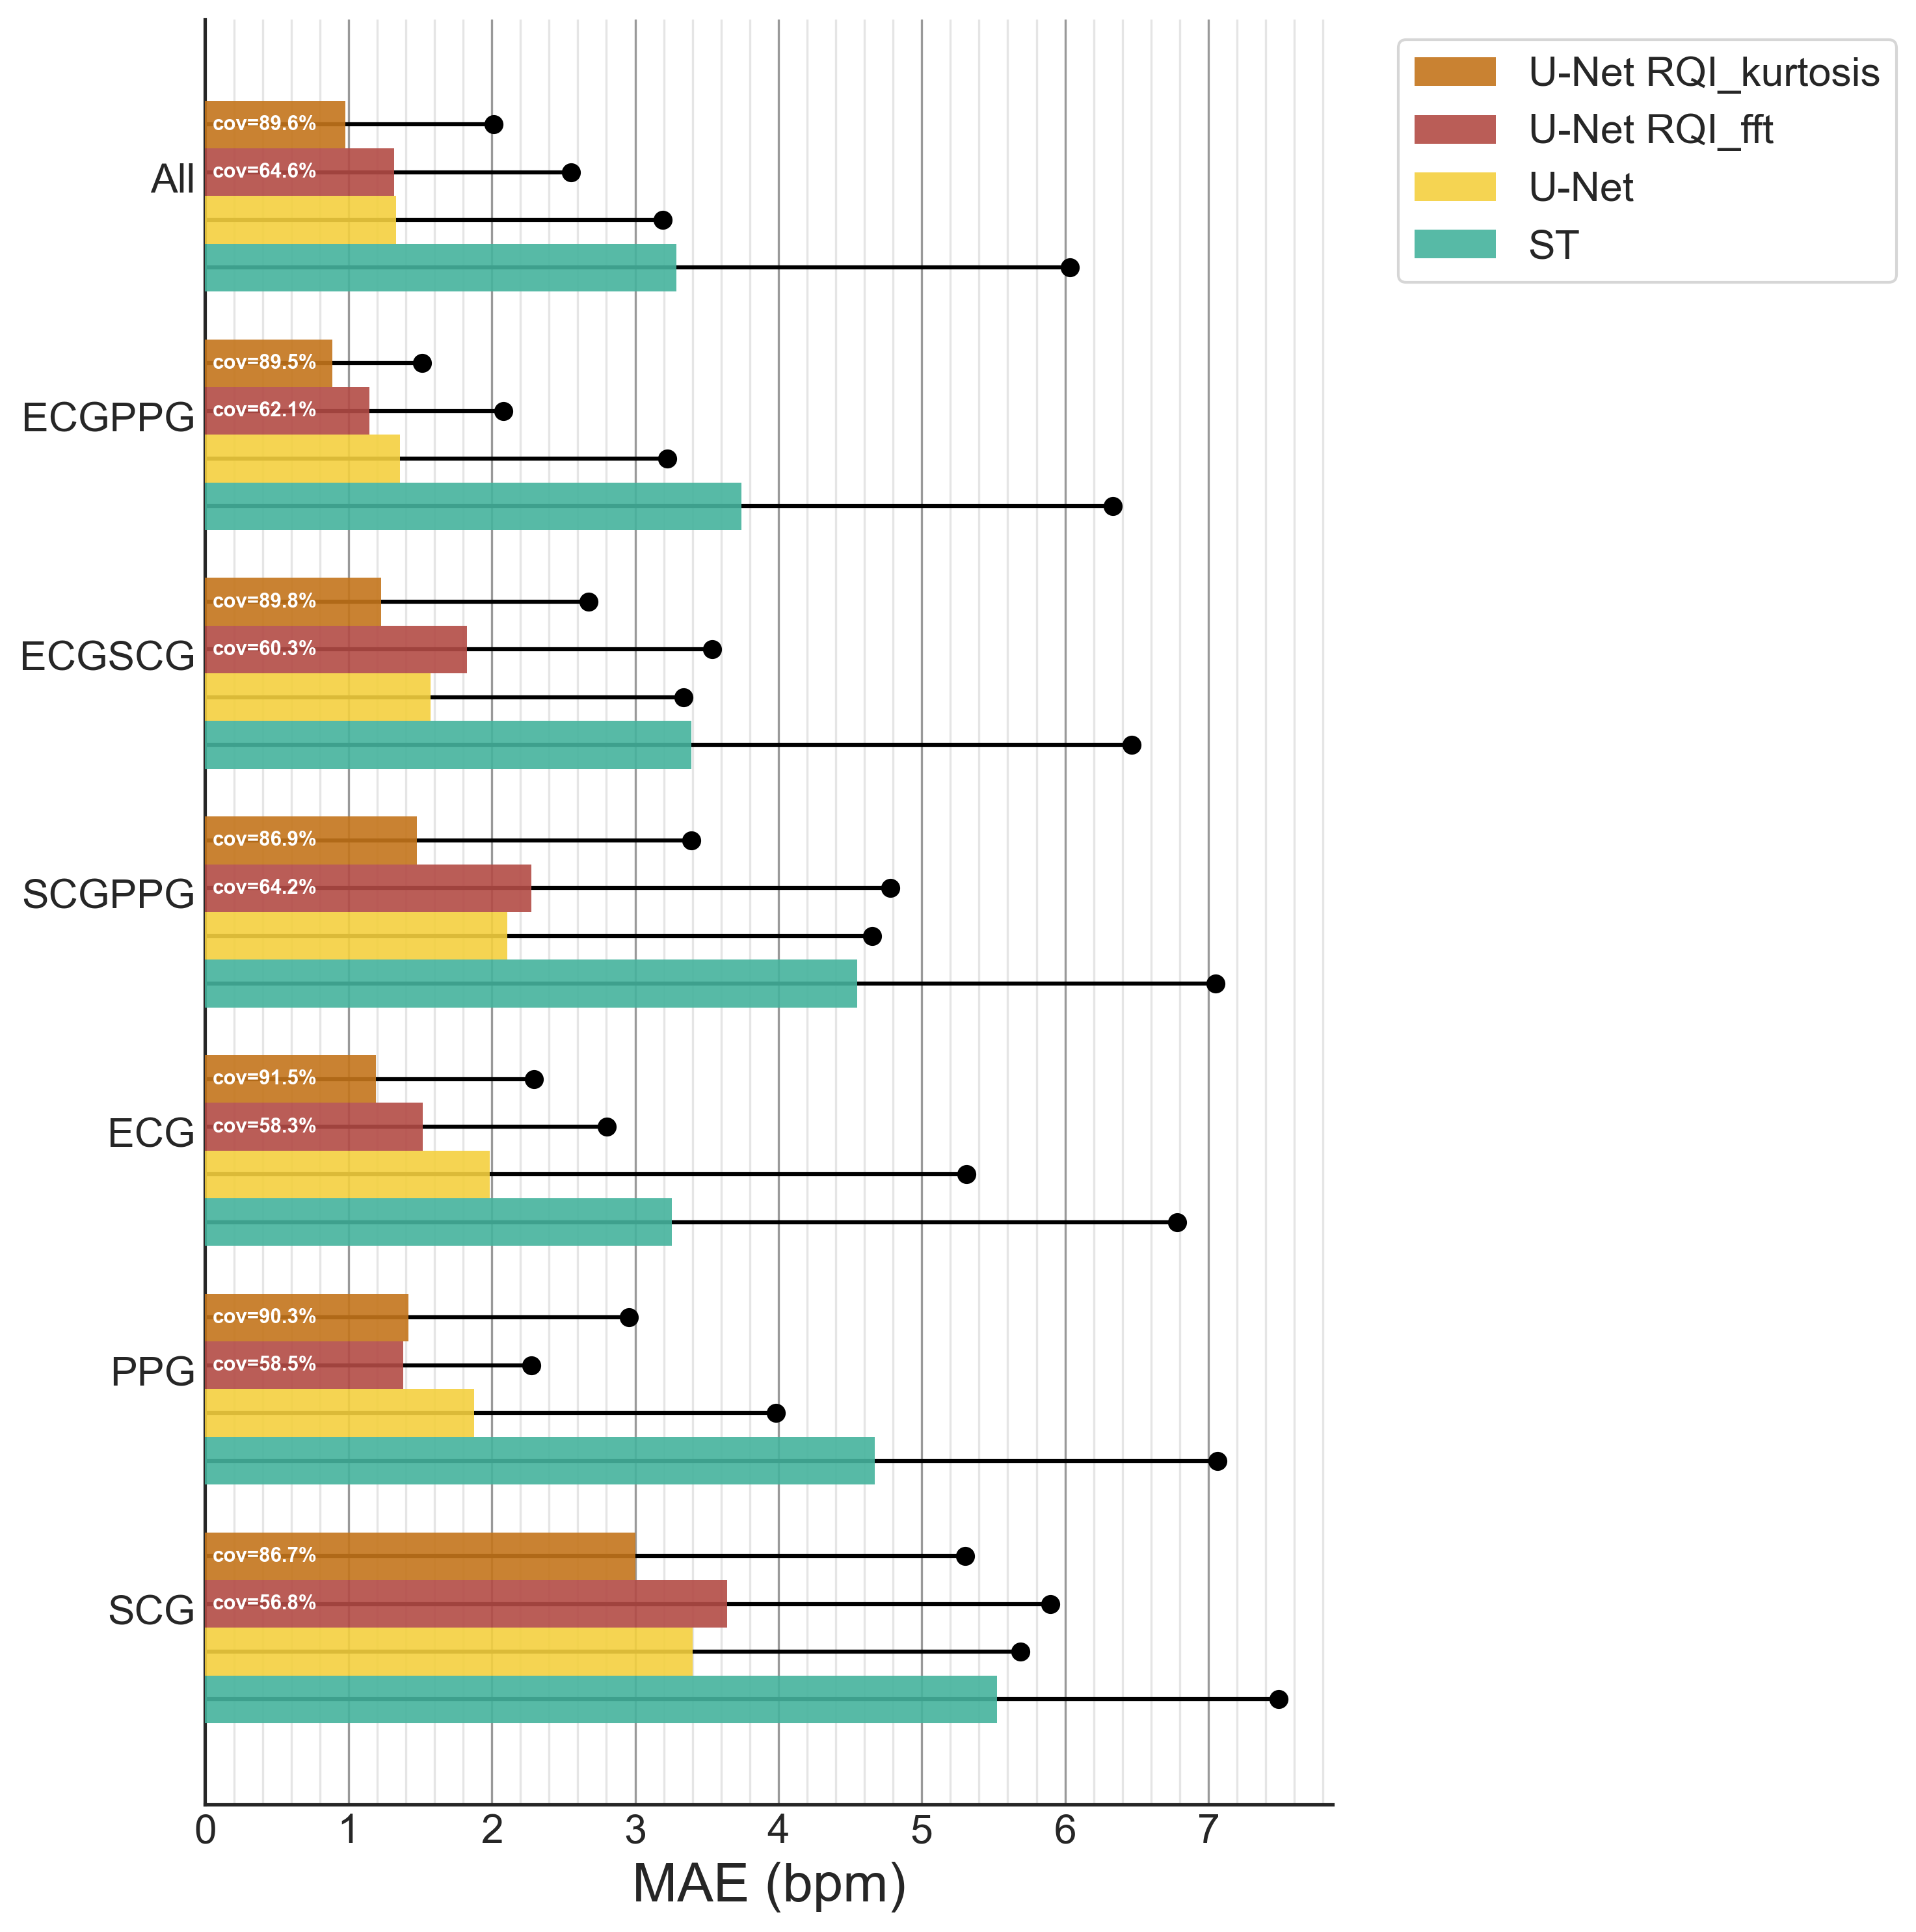

In [75]:
plot_figure_ranking_all(df_performance_agg, outputdir=outputdir, show_plot=True)


# RQI analysis (coverage vs. MAE)

In [76]:
df_RQI_results_final = pd.DataFrame()

for modality in df_outputlabel_ALL['modality'].unique():
    for est_method in df_outputlabel_ALL['est_method'].unique():
        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method)
        df_outputlabel = df_outputlabel_ALL[mask_df]
        
        for RQI_name in ['random', 'RQI_kurtosis', 'RQI_fft', 'RQI_ideal']:
            df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
            df_RQI_results['RQI_name'] = RQI_name
            df_RQI_results['est_method'] = est_method
            df_RQI_results['modality'] = modality

            df_RQI_results_final = df_RQI_results_final.append(df_RQI_results)

In [77]:
df_RQI_results_final

,threshold,coverage,MAE,RQI_name,est_method,modality
0,0.00,100.000000,3.739636,random,ST,ECGPPG
1,19.78,99.039434,3.749362,random,ST,ECGPPG
2,39.56,98.028311,3.727179,random,ST,ECGPPG
3,59.34,97.017189,3.728504,random,ST,ECGPPG
4,79.12,96.006067,3.725118,random,ST,ECGPPG
...,...,...,...,...,...,...
95,-2.20,82.962588,0.503961,RQI_ideal,U-Net,ECG
96,-1.76,75.126390,0.347914,RQI_ideal,U-Net,ECG
97,-1.32,75.126390,0.347914,RQI_ideal,U-Net,ECG
98,-0.88,48.988878,0.000000,RQI_ideal,U-Net,ECG


In [78]:
# df_RQI_results['RQI_name'].unique()

In [79]:
def plot_MAEoverCoverage(ax, df_RQI_results, modality, est_method):
    fontsize = 10
    sns.lineplot(data=df_RQI_results, x="coverage", y="MAE", hue="RQI_name",ax=ax, palette=method_color_dict,alpha=0.8)
    ax.invert_xaxis()
    ax_no_top_right(ax)
    ax.set_xlim(100,50)
    ax.set_ylim(0,6)
    ax.set_xlabel('Coverage (%)', fontsize=fontsize)
    ax.set_ylabel('MAE (BPM)', fontsize=fontsize)
    ax.set_title('{} ({})'.format(modality, est_method), fontsize=fontsize+3)
    ax.legend().set_visible(False)


In [80]:
# axes.shape

In [81]:
# list_method
# list_modalitites
# # N_est_method, N_modality

In [82]:
method_color_dict = {
    'random': '#999898',
    'RQI_ideal':'#433F3F' ,
    'RQI_fft':'#b34b45' ,
    'RQI_kurtosis':'#c4751b' ,
}

In [83]:
# df_RQI_results_final['RQI_name'].unique()

In [28]:

# N_modality
N_est_method = len(df_RQI_results_final['est_method'].unique())
N_modality = len(df_RQI_results_final['modality'].unique())

# fig, axes = plt.subplots(N_modality,N_est_method, figsize=(4,10), dpi=150)
fig, axes = plt.subplots(N_est_method, N_modality, figsize=(12,4), dpi=150)
# fig, axes = plt.subplots(N_est_method, N_modality, figsize=(20,12), dpi=150)

# for i_mod, modality in enumerate(df_RQI_results_final['modality'].unique()):
for i_mod, modality in enumerate(list_modalitites):
    for i_est, est_method in enumerate(df_RQI_results_final['est_method'].unique()):
#         print(i_mod, i_est)
        mask_df = (df_RQI_results_final['modality']==modality) & (df_RQI_results_final['est_method']==est_method)
        df_RQI_results = df_RQI_results_final[mask_df]
        ax = axes[i_est, i_mod]
        plot_MAEoverCoverage(ax, df_RQI_results, modality, est_method)
#         ax.legend( bbox_to_anchor=(1.04,1.04))
#         sys.exit()
fig.tight_layout()
# axes[0,0].plot(np.arange(5))
# axes[0,0].plot(np.arange(5))

NameError: name 'df_RQI_results_final' is not defined

In [85]:
sys.exit()

SystemExit: 

/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
